<a href="https://colab.research.google.com/github/pscabral/IFMA_Softex/blob/main/mobilenetv2_2.00_160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
import gdown

# Especifique o ID do arquivo e o nome do arquivo de saída
file_id = '1aX48j7lKyE0c66tMZEesOwNncFbyvu6X'
output = 'dataset.zip'

# Baixe o arquivo do Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)
!unzip dataset.zip

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/dataset_3'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [55]:
train_dir = '/content/dataset_3/train'
test_dir = '/content/dataset_3/test'
val_dir = '/content/dataset_3/validation'

In [56]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [57]:
# Create a list with the filepaths for training and testing
train_dir = Path('../content/dataset_3/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('../content/dataset_3/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [58]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures: 3465

Number of different labels: 36

Labels: ['grapes' 'carrot' 'banana' 'beetroot' 'garlic' 'paprika' 'sweetpotato'
 'apple' 'eggplant' 'cucumber' 'cauliflower' 'mango' 'sweetcorn' 'ginger'
 'corn' 'spinach' 'bell pepper' 'kiwi' 'tomato' 'lemon' 'pear' 'turnip'
 'chilli pepper' 'onion' 'soy beans' 'potato' 'cabbage' 'orange' 'peas'
 'capsicum' 'raddish' 'pomegranate' 'pineapple' 'watermelon' 'lettuce'
 'jalepeno']


Filepath     Label
0     ../content/dataset_3/train/grapes/Image_9.jpg    grapes
1    ../content/dataset_3/train/carrot/Image_88.jpg    carrot
2    ../content/dataset_3/train/banana/Image_16.jpg    banana
3  ../content/dataset_3/train/beetroot/Image_32.jpg  beetroot
4    ../content/dataset_3/train/grapes/Image_30.jpg    grapes

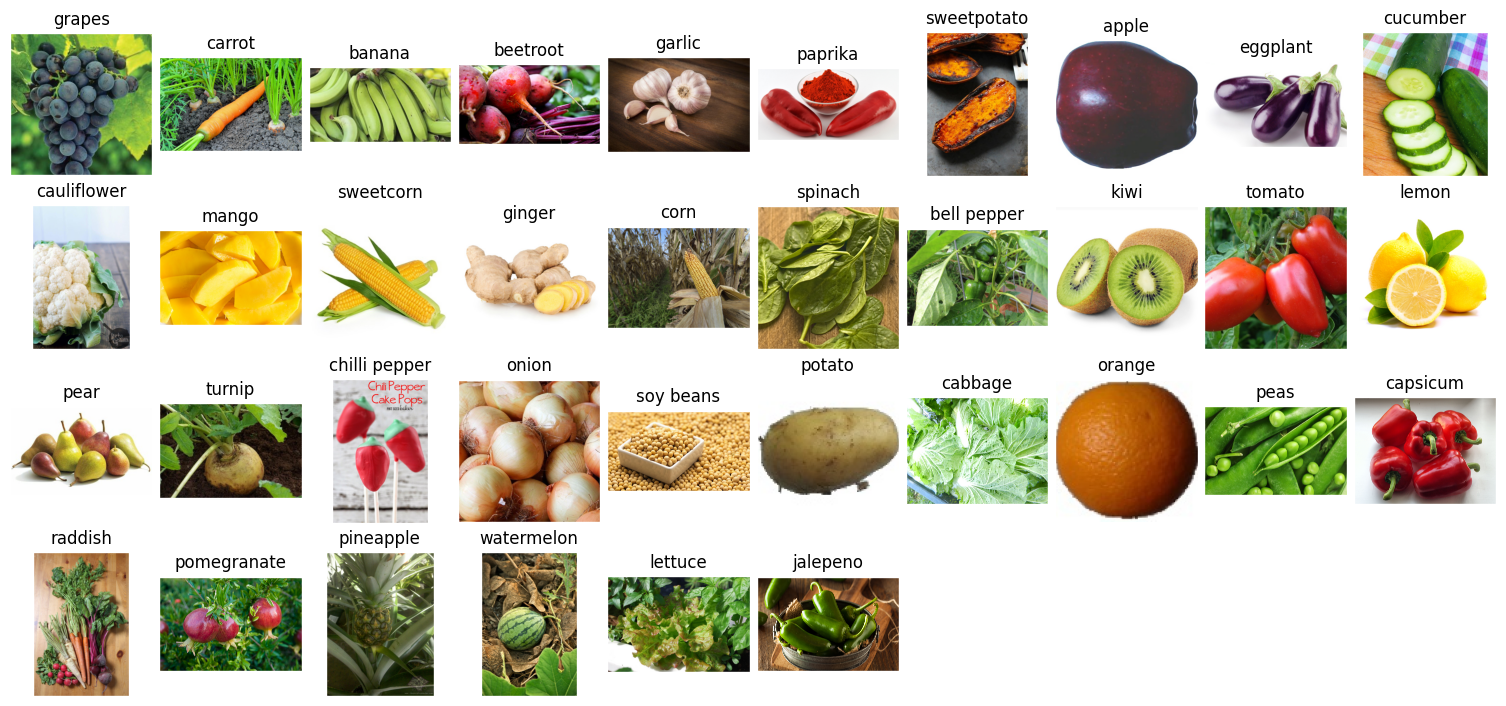

In [59]:
# Create a DataFrame with one Label of each category
df_unique = train_df.drop_duplicates(subset=["Label"]).reset_index(drop=True)

# Display some pictures of the dataset
n_rows = 4
n_cols = 10
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(df_unique):
        ax.imshow(plt.imread(df_unique.Filepath[i]))
        ax.set_title(df_unique.Label[i], fontsize=12)
    else:
        ax.axis('off')  # Turn off empty subplots

plt.tight_layout(pad=0.5)
plt.show()

In [61]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2772 validated image filenames belonging to 36 classes.
Found 693 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [62]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [63]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=30
)

Epoch 1/30
87/87 [==============================] - 196s 2s/step - loss: 1.6682 - accuracy: 0.5563 - val_loss: 0.7990 - val_accuracy: 0.7662
Epoch 2/30
87/87 [==============================] - 187s 2s/step - loss: 0.5132 - accuracy: 0.8387 - val_loss: 0.5519 - val_accuracy: 0.8384
Epoch 3/30
87/87 [==============================] - 186s 2s/step - loss: 0.3054 - accuracy: 0.9091 - val_loss: 0.5584 - val_accuracy: 0.8355
Epoch 4/30
87/87 [==============================] - 184s 2s/step - loss: 0.1725 - accuracy: 0.9441 - val_loss: 0.5584 - val_accuracy: 0.8326
Epoch 5/30
87/87 [==============================] - 189s 2s/step - loss: 0.1110 - accuracy: 0.9733 - val_loss: 0.5268 - val_accuracy: 0.8442
Epoch 6/30
87/87 [==============================] - 189s 2s/step - loss: 0.0806 - accuracy: 0.9758 - val_loss: 0.5950 - val_accuracy: 0.8398
Epoch 7/30
87/87 [==============================] - 195s 2s/step - loss: 0.0622 - accuracy: 0.9816 - val_loss: 0.5606 - val_accuracy: 0.8456
Epoch 8/30
87

In [64]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

11/11 [==============================] - 24s 2s/step
The first 5 predictions: ['cucumber', 'beetroot', 'sweetcorn', 'sweetcorn', 'corn']


In [65]:
from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 94.31%


In [66]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

               precision    recall  f1-score   support

        apple       0.75      0.67      0.71         9
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.90      1.00      0.95         9
      cabbage       1.00      1.00      1.00        10
     capsicum       0.89      0.89      0.89         9
       carrot       1.00      1.00      1.00         7
  cauliflower       1.00      1.00      1.00         9
chilli pepper       0.75      0.86      0.80         7
         corn       1.00      0.70      0.82        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         8
     jalepeno       0.82      1.00      0.90         9
         kiwi       1.00      1.00      1.00        10
        l

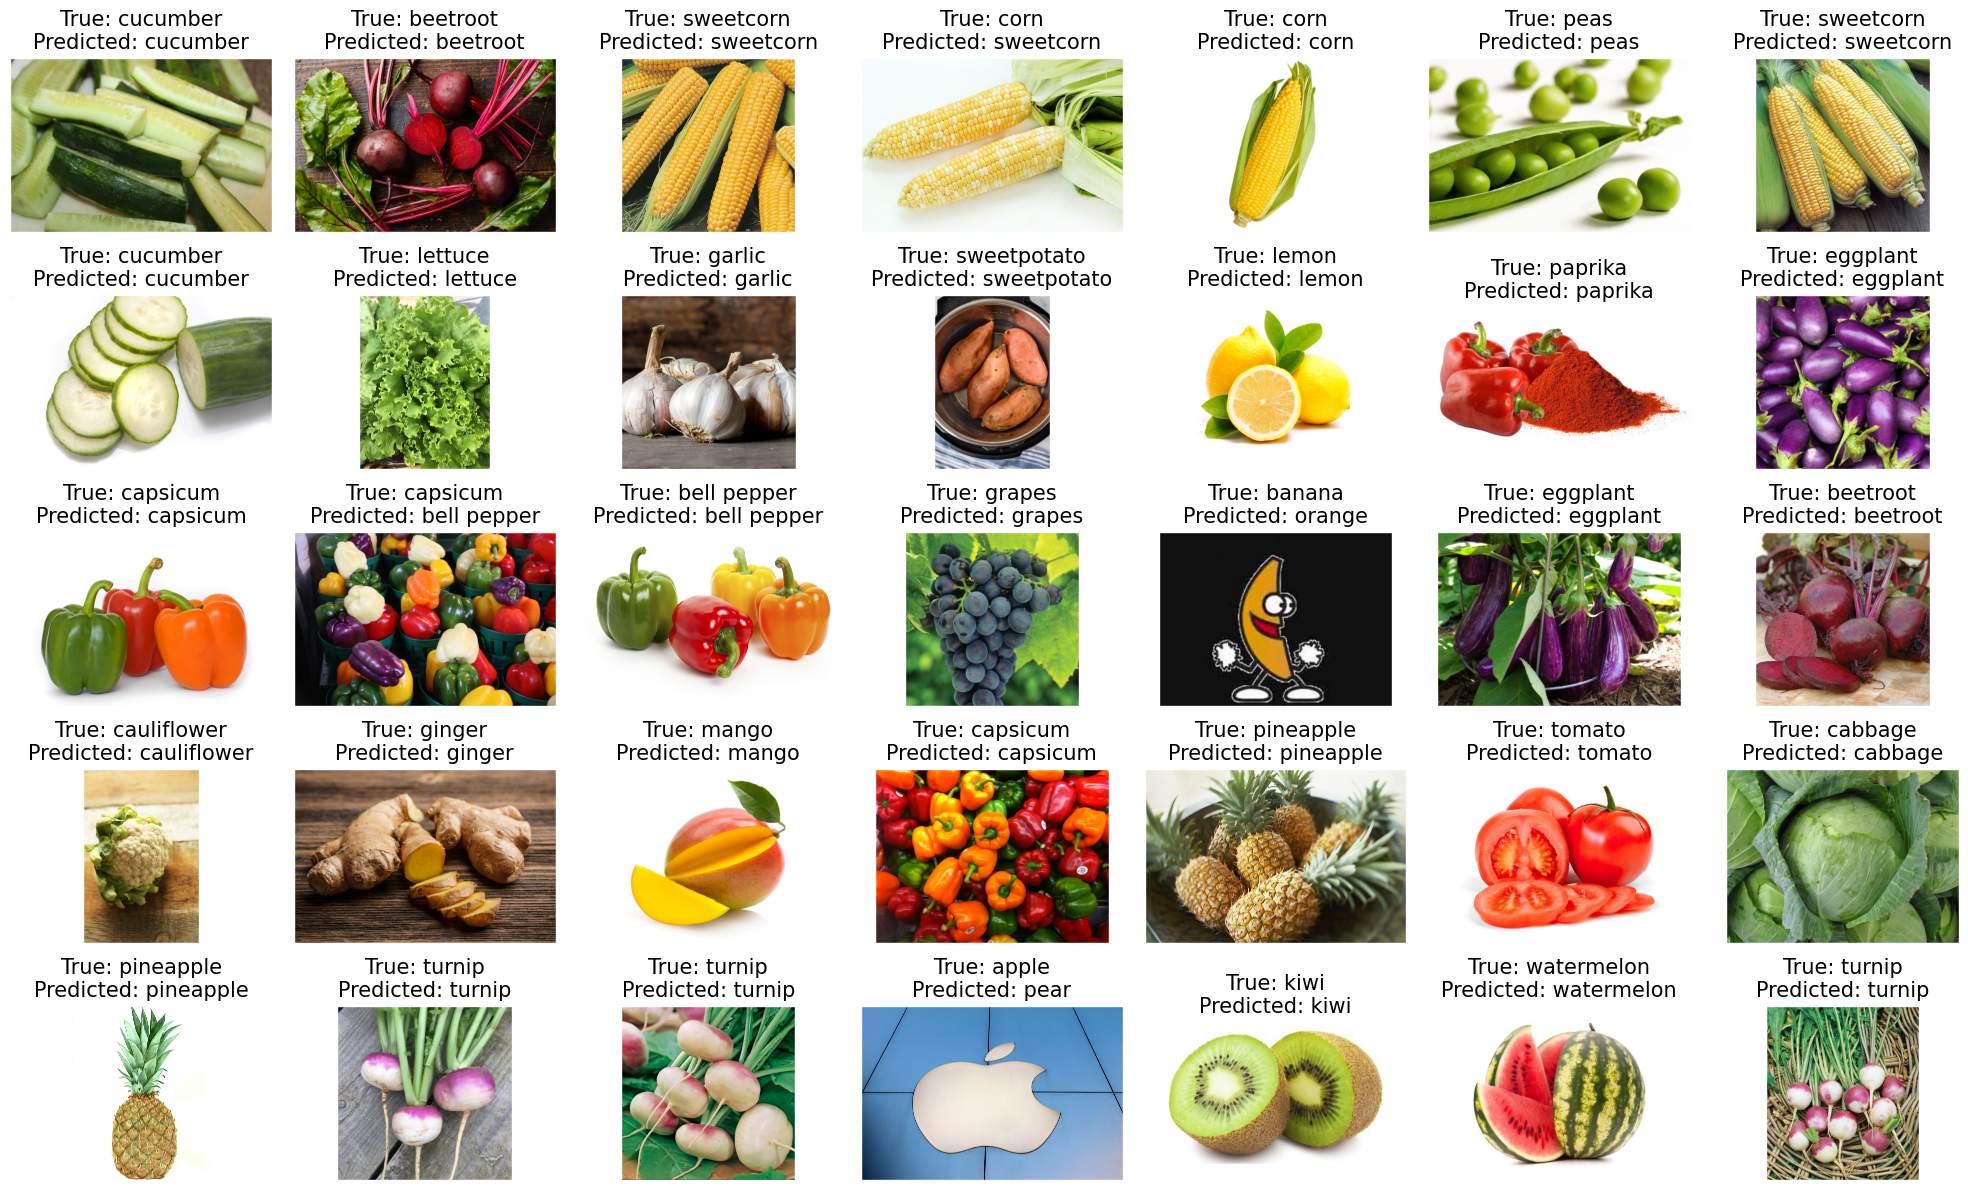

In [67]:
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [68]:
def plot_graghs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

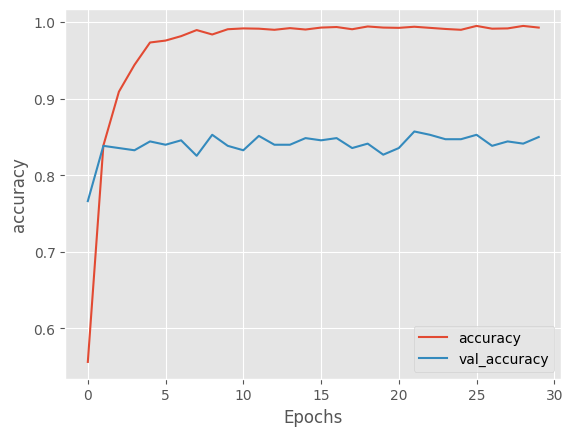

In [69]:
plot_graghs(history, 'accuracy')

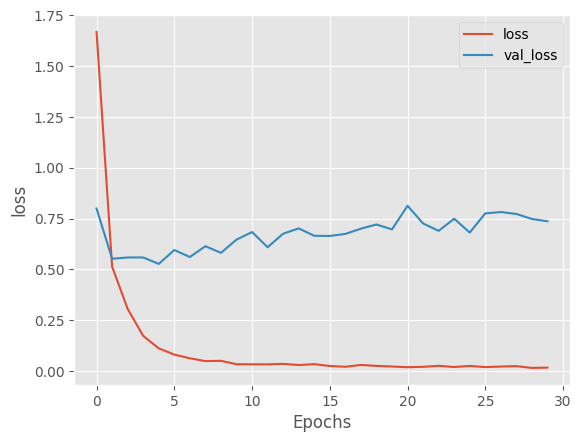

In [70]:
plot_graghs(history, 'loss')

Text(0.5, 0, 'N.of Epochs')

<Figure size 640x480 with 0 Axes>

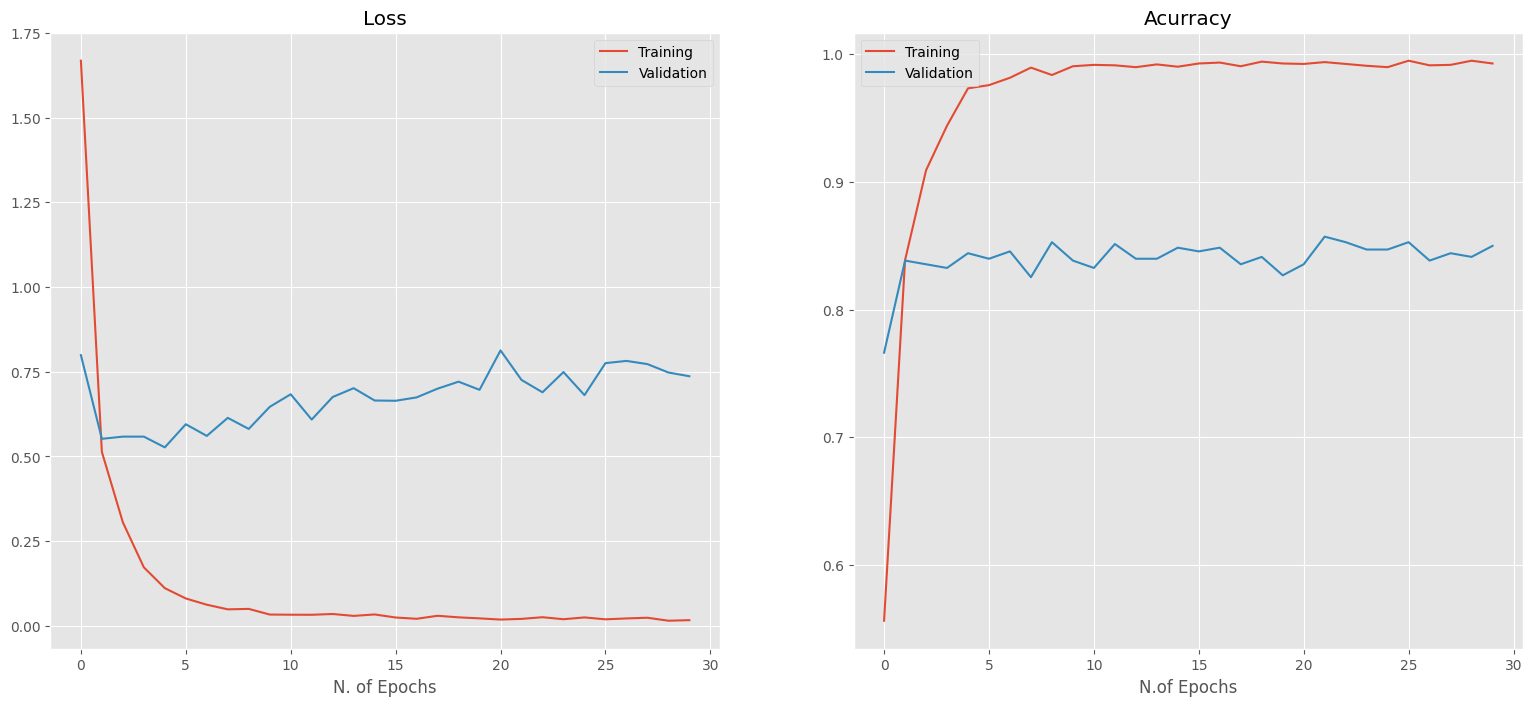

In [71]:
# Plot training loss vs validation loss
plt.style.use('ggplot')
plt.figure()
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(19,8))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training','Validation'])
ax1.set_title('Loss')
ax1.set_xlabel('N. of Epochs')
## plot training accuracy vs validation accuracy
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training','Validation'])
ax2.set_title('Acurracy')
ax2.set_xlabel('N.of Epochs')

In [72]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
pred

11/11 [==============================] - 24s 2s/step


array([10,  2, 31, 31,  9, 24, 31, 10, 18, 12, 32, 17, 22, 11,  5,  3,  3,
       14, 21, 11,  2,  7, 13, 19,  5, 25, 33,  4, 25, 34, 34, 23, 16, 35,
       34,  6, 26, 29,  5, 24, 14, 32, 11, 13, 33,  9, 18, 16, 31, 15, 28,
       27, 32, 24,  4, 23, 33, 30, 20, 29, 23,  3, 18, 33,  4, 14, 15, 10,
       33, 29, 19, 27,  2,  7,  7, 35, 13, 13, 25, 21, 31, 15, 12, 17,  3,
       31, 31, 26, 23,  8, 31, 24, 17, 22, 14, 26, 25, 26, 20,  4, 21, 29,
       18, 28,  5,  2, 33,  3, 23, 26, 30,  5, 29,  3, 30, 10, 32, 28,  7,
       12, 23, 16, 19, 28, 20, 23,  6,  4, 32, 35, 12, 21, 22,  0, 25,  6,
        0, 16,  0, 12,  4, 19, 27, 30, 20, 19, 31, 15,  2, 26, 28, 12,  8,
       32,  0, 16, 11,  1,  2, 34,  0,  0, 24, 13, 10,  8, 20,  4, 24, 35,
       19, 10, 30, 20, 35, 32, 30, 35, 13, 16, 21, 27, 16,  4, 30,  0, 18,
        4, 14, 34, 25, 29,  1, 17, 18, 18,  2, 23, 11, 28,  9, 13, 15, 34,
       10, 28, 18,  7, 27, 10, 34,  4, 15,  7, 26,  5, 25, 28, 34, 19,  5,
        6, 21, 19,  2, 15

In [73]:
labels = (train_images.class_indices)
labels

{'apple': 0,
 'banana': 1,
 'beetroot': 2,
 'bell pepper': 3,
 'cabbage': 4,
 'capsicum': 5,
 'carrot': 6,
 'cauliflower': 7,
 'chilli pepper': 8,
 'corn': 9,
 'cucumber': 10,
 'eggplant': 11,
 'garlic': 12,
 'ginger': 13,
 'grapes': 14,
 'jalepeno': 15,
 'kiwi': 16,
 'lemon': 17,
 'lettuce': 18,
 'mango': 19,
 'onion': 20,
 'orange': 21,
 'paprika': 22,
 'pear': 23,
 'peas': 24,
 'pineapple': 25,
 'pomegranate': 26,
 'potato': 27,
 'raddish': 28,
 'soy beans': 29,
 'spinach': 30,
 'sweetcorn': 31,
 'sweetpotato': 32,
 'tomato': 33,
 'turnip': 34,
 'watermelon': 35}

In [74]:
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 94.31%


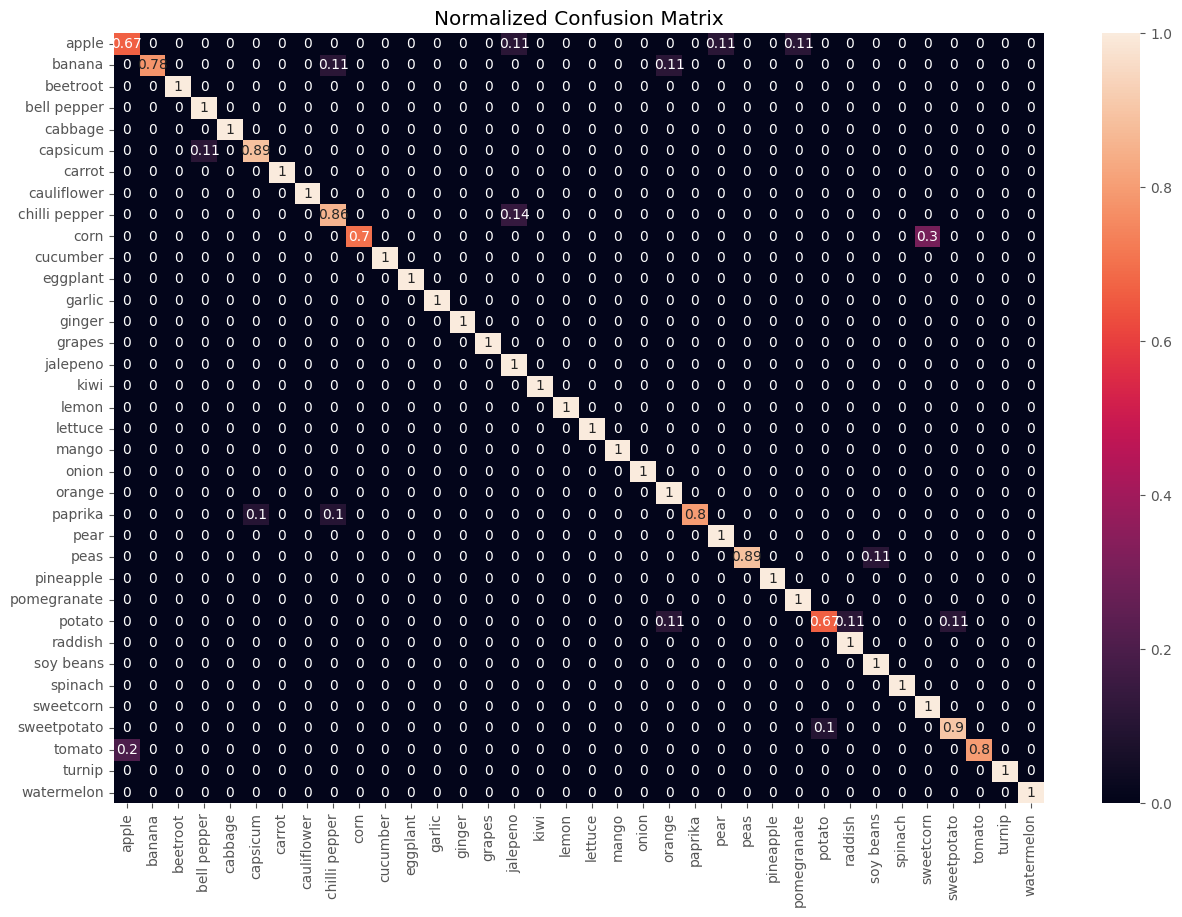

In [75]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True,
            xticklabels = sorted(set(y_test)),
            yticklabels = sorted(set(y_test))
           )
plt.title('Normalized Confusion Matrix')
plt.show()

In [76]:
# Salvar o modelo
model.save('/content/MobileNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Carregar o modelo treinado
model = tf.keras.models.load_model('/content/MobileNet.h5')

# Preparar o conjunto de dados de teste
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/dataset_3/test',
    target_size=(224, 224),  # Tamanho das imagens de entrada esperado pelo modelo
    batch_size=32,
    class_mode='categorical'  # Modo de classificação (pode variar dependendo do seu modelo)
)

# Fazer previsões
predictions = model.predict(test_generator)

# Agora você pode processar as previsões, calcular métricas de desempenho, etc.

Found 359 images belonging to 36 classes.
12/12 [==============================] - 27s 2s/step


In [78]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np

# Carregue o modelo MobileNetV2 treinado
model = MobileNetV2(weights='imagenet')

# Carregue e pré-processe a imagem de entrada
img_path = '/content/Untitled Folder/Frutas01.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Ajuste o tamanho da imagem de acordo com o MobileNetV2
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Faça a inferência
predictions = model.predict(x)

# Decodifique as previsões
decoded_predictions = decode_predictions(predictions, top=5)[0]

# Imprima as previsões
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")


1/1 [==============================] - 1s 1s/step
1: pineapple (0.24)
2: strawberry (0.12)
3: lemon (0.11)
4: orange (0.06)
5: banana (0.06)
